# RAM Computational Pipeline

This tutorial demonstrates how to build Logistic Regression Classifier of Good memory for a single patient in 30 lines of code. The code is based on the refactored PTSA toolkit that uses xarray as a core container for the time series data. To construct classifier we will need two classes of objects:
1. **Readers**
2. **Filters**

Readers are objects that read data store on the hard drive. For the purpose of building memory classifiers we need the following readers:
1. **BaseEventReader** - an object that reads so called events files (stored in Matlab format)
2. **TalReader** - an object that reads the so called "Tal Structs" i.e. the information about pairing of bipolar electrodes, location of electrods specified in various coordinates systems and name of the brain areas where electrodes are placed.
3. **EEGReader** - and object that reads raw EEG for specified events and electrodes

We will use 3 filter objects:
1. **MonopolarToBipolarFilter** - an onbject that takes as an input monopolar time series (as returned by **EEGReader**) and returns another time series where for each bipolar pair we form a series that is difference of two monopolar time series as specified as given by the bipolar pair specification. For example, we may have 100 monopolar electrodes but the number of bipolar pairs wcould be 125 or so. **MonopolarToBipolarFilter** will transform an input time series corresponding witj monopolar data to the one corresponding to bipolar data
2. **ButterworthFiler** -  an object that applies Butterworth filter along time axis of the series. For example our time series can be represented by a 3-dimensional array with dimensions *"bipolar_pairs"*, *"events"* and *"time"*and in this case **ButterworthFilter** will do filtering along *"time"* dimension
3. **MorletWaveletFilter** - an object that takes as an input a time series, applies continuous wavelet convolution along time axis and returns another time series of wavelet coeeficients (represented as power and phase arrays). For example our time series can be represented by a 3-dimensional array with dimensions *"bipolar_pairs"*, *"events"* and *"time"* and in this case **MoreletWaveletFilter** would return 4-dimensional array of wavelet coeeficients (power, phase) with dimensions being *frequency*, *"bipolar_pairs"*, *"events"* and *"time"*, where *frequency* is center wavelet frequency.

First let us start by importing modules/classes that we will need in our computational pipeline:


In [1]:
import sys
sys.path.append('/Users/m/PTSA_NEW_GIT/')
import numpy.testing 
import numpy as np
from ptsa.data.readers import BaseEventReader
from ptsa.data.readers.TalReader import TalReader
from ptsa.data.readers import EEGReader
from ptsa.data.filters import MonopolarToBipolarMapper
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters.MorletWaveletFilter import MorletWaveletFilter
from ptsa.data.common import xr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats.mstats import zscore
from time import time
start_time = time()

Could not find compiled version of c library for handing edf files. If you want edf support, please run setup.py and compile this library


Notice that I manually appended a path */Users/m/PTSA_NEW_GIT/* to point Python to the location of the PTSA package. If you installed PTSA into your default directory you can skip this step but if you get stragne import errors it is a reasonable initial guess to ass=ume that Python is unable to find PTSA and in this case specifying location of PTSA should resolve the problems. Once our imports suceed we will specify paths to events and "tal structs" files and read the content of those:

In [2]:
e_path = '/Users/m/data/events/RAM_FR1/R1111M_events.mat'
tal_path = '/Users/m/data/eeg/R1111M/tal/R1111M_talLocs_database_bipol.mat'
# ------------------- READING TAL STRUCTS
tal_reader = TalReader(filename=tal_path)
monopolar_channels = tal_reader.get_monopolar_channels()
bipolar_pairs = tal_reader.get_bipolar_pairs()
# ------------------- READING EVENTS
base_e_reader = BaseEventReader(filename=e_path, eliminate_events_with_no_eeg=True)
base_events = base_e_reader.read()
base_events = base_events[base_events.type == 'WORD']

After we read events and "tal structs" we are ready to read raw eeg **monopolar** data. To do that we create an EEGReader object passing the following information as arguments of the constructor:

1. *events* - numpy recarray storing the content of events file
2. *channels* - numpy array of monopolar channel labels
3. *start_time* - an offset expressed in units of seconds that specifies where the read statrts relative the to event position in the eeg file
3. *end_time* - an offset expressed in units of seconds that determines where the read ends rrelative the to event position in the eeg file
4. *buffer_time* - extra buffer (specified in units of seconds) added before start_time_position and after end_time position


In [3]:
eeg_reader = EEGReader(events=base_events, channels=monopolar_channels,
                       start_time=0.0, end_time=1.6, buffer_time=1.0)

base_eegs = eeg_reader.read()

At this point all the data necessary to construct our memory classifier is loaded into computer memory and we are ready to process it. Since we are interested in looing at potential difference between electrodes we will first need to transform monopolar data to the the one where time series are differences between appropriate monopolar data.It is instructive to look at the raw eeg data. Notice that I shortened the output by using *base_eegs[0:2,0:2,0:300]* 

In [4]:
base_eegs[0:2,0:2,0:300]

<xray.TimeSeriesX (channels: 2, events: 2, time: 300)>
array([[[ 3467.059196,  3471.312604,  3473.970984, ...,  3565.950932,
          3574.989424,  3576.052776],
        [ 3609.548364,  3609.548364,  3612.73842 , ...,  3552.659032,
          3548.405624,  3543.62054 ]],

       [[-3652.082444, -3648.360712, -3645.170656, ..., -3497.896404,
         -3497.364728, -3505.339868],
        [-3565.950932, -3568.609312, -3573.394396, ..., -3492.047968,
         -3489.389588, -3483.009476]]])
Coordinates:
    samplerate  float64 499.7
  * channels    (channels) |S3 '001' '002'
  * events      (events) (numpy.record, [('subject', 'S256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', 'S256'), ('item', 'S256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('isStim', '<i8'), ('expVersion', 'S256'), ('stimLoc', 'S256'), ('stimAmp', '<f8'), ('stimAnode', '<f8'), ('stimCathode', '<f8'), ('stimList', '

As we can see raw EEG data (*base_eegs*) is a 3D array with axes corresponding to *channels*, *events* and *time*. To access a single time seriec for a given channel (say channel 0 where zero refers to index of the channel not its label) and a given event (say 0th event) we would type:

In [5]:
base_eegs[0,0,:]

<xray.TimeSeriesX (time: 1800)>
array([ 3467.059196,  3471.312604,  3473.970984, ...,  3580.306184,
        3581.901212,  3588.813   ])
Coordinates:
    samplerate  float64 499.7
    channels    |S3 '001'
    events      (numpy.record, [('subject', 'S256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', 'S256'), ('item', 'S256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('isStim', '<i8'), ('expVersion', 'S256'), ('stimLoc', 'S256'), ('stimAmp', '<f8'), ('stimAnode', '<f8'), ('stimCathode', '<f8'), ('stimList', '<i8'), ('eegfile', 'S256'), ('eegoffset', '<i8')]) ('R1111M', 0, 1, 1, 'WORD', 'BEAR', 17, 1, 1453499295325.0, 1, 5211, -999, 0, 'v_1.05', 'X', nan, nan, nan, 0, '/Users/m/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Jan16_1638', 100521) ...
  * time        (time) float64 -1.0 -0.998 -0.996 -0.994 -0.992 -0.99 -0.988 ...
Attributes:
    samplerate: 499.71
    gain: 0.531676
    fo

Let us plot this data. First lets import matplotlib and ensure that ipython notebook can inline the plots

In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Now we can do the plot:

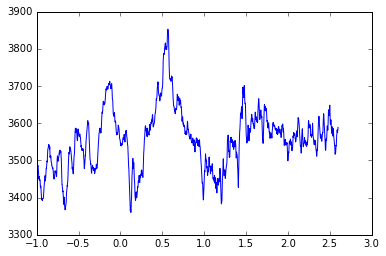

In [7]:
plt.plot(base_eegs['time'],base_eegs[0,0,:])

Notice that I refered to a *time* axis in the eeg data (*base_eegs*) as *base_eegs['time']*. Now let's do two other plots one showing raw eeg data for the channel with index 1 (i.e. second monopolar channels - as we start counding from 0 in Python) and another the dirrefence the voltage difference between the two channels

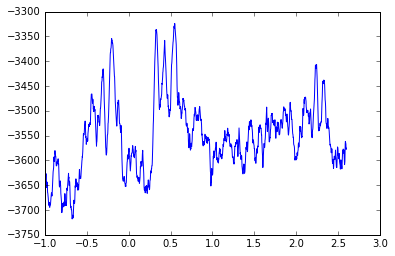

In [8]:
plt.plot(base_eegs['time'],base_eegs[1,0,:])

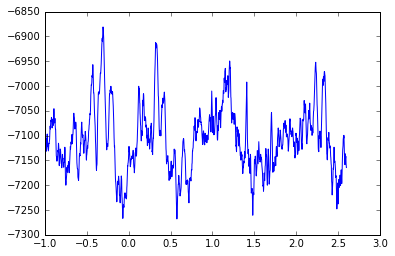

In [9]:
plt.plot(base_eegs['time'],base_eegs[1,0,:]-base_eegs[0,0,:])

Before applying **MonopoarToBipolarFilter** lets take a look at the bipolar pairs

In [10]:
bipolar_pairs[0:3]

rec.array([('001', '002'), ('001', '009'), ('002', '003')], 
          dtype=[('ch0', 'S3'), ('ch1', 'S3')])

and also let us examine monopolar channels:

In [11]:
monopolar_channels[0:10]

array(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010'], 
      dtype='|S3')

as you can see based onthe specification of the first bipolar pairs for the first pairs we need to subtract values time series of channels with labels '001' and '002', for the second one we subtract time series for channels with labels '001' and '009', etc... We write a loop to do this manually or we can use **MonopolarToBipolarMapper** that does exactly these operations for us:

In [12]:
m2b = MonopolarToBipolarMapper(time_series=base_eegs, bipolar_pairs=bipolar_pairs)
bp_eegs = m2b.filter()


Let us check if indeed **MonopolarToBipolarMapper** does what we expect and compare first two bipolar time series reported by the mapper to the values we woudld obtain using manual calculations:

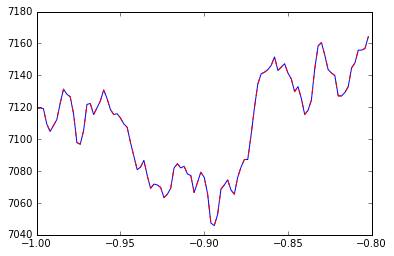

In [13]:
first_bp = bp_eegs[0,0,:]
second_bp = bp_eegs[1,0,:]

first_bp_manual = base_eegs[0,0,:]-base_eegs[1,0,:]
second_bp_manual = base_eegs[0,0,:]-base_eegs[8,0,:]

numpy.testing.assert_array_equal(first_bp_manual, first_bp)
numpy.testing.assert_array_equal(second_bp_manual, second_bp)

plt.plot(first_bp['time'][0:100], first_bp[0:100],'b')
plt.plot(first_bp_manual['time'][0:100], first_bp_manual[0:100],'r--')



As you can see the action of the **MonopolarToBipolarMapper** matches our "manual" computations so at this point we are ready to filter out unwanted frequencies from our bipolar EEG spectrum. We will Apply ButterworthFilter to supporess signal components in the 58 -62 Hz bandwidth:

In [14]:
b_filter = ButterworthFilter(time_series=bp_eegs, freq_range=[58., 62.], filt_type='stop', order=4)
bp_eegs_filtered = b_filter.filter()

Now we are ready to compute wavelet coefficients for our filtered time series of bipolar EEG data. To do that we will use object called **MorletWaveltFilter** that takes as its constructor parameters *time_series* object for which we compute wavelets, an array of center wavelet frequencies - *freqs* (here we are using 8 frequencies that are logaritmically-spacedbetween 3 and 180 Hz) and optional parameter that specifies the return value - here we return power so the *output* parameter has value *'power'* . To allow rudimentary benchmarking of the code we will measure time it takes for the **MorletWaveletFilter** to carry out its computations. Notice that the *filter()* function of the **MorletWaveletFilter** returns two objects -  power and phase arrays. Since we are requesting power coeeficients only the phase array will be set to *None*.

In [15]:
s = time()
wf = MorletWaveletFilter(time_series=bp_eegs_filtered,
                         freqs=np.logspace(np.log10(3), np.log10(180), 8),
                         output='power'                   
                         )

pow_wavelet, phase_wavelet = wf.filter()
print 'TOTAL WAVELET TIME=', time()-s

total time wavelet loop:  123.173135996
TOTAL WAVELET TIME= 123.18047595


Now that we have wavelets computted we will remove buffer to truncate those segments of time series for which wavelet convolution is "contaminated" by so called edge effects. We will also tak logarithm of the powers to handle  the fact that spectral powers in the EEG signals show power-law decay with increasing frequencies

In [16]:
pow_wavelet = pow_wavelet.remove_buffer(duration=1.0)
np.log10(pow_wavelet.data, out=pow_wavelet.data);

For the subsequent analysis we will need to reorder the axes of the wavelet power array and compute the mean power across encoding epoch as follows:

In [17]:
pow_wavelet = pow_wavelet.transpose("events","bipolar_pairs","frequency","time")
mean_powers_nd = pow_wavelet.mean(skipna=True,axis=-1)

In [18]:
a = np.arange(12).reshape(3,4)
print a
a_z = zscore(a, axis=0, ddof=1)
a_z

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([[-1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.]])

Once we computed mean powers we are essentially ready to compute classifier, but first we will normalize features (i.e. mean power for each combination of bipolar pair and spectral freqnency) accross the events we will use to train the classifier. As a first step however we will reshape mean_powers_nd array (with dimensions *events*, *bipolar_pair*, *frequency*) to a 2-D array where one axis will correspond to events and the other one will be a Cartesian product of *bipolar_pair* and *frequency* axes:

In [19]:
mean_powers_rs = mean_powers_nd.data.reshape(mean_powers_nd.data.shape[0],-1)

first axis of *mean_powers_nd* corresponds to *events* and the second one corresponds to Cartesian product of *bipolar_pair* and *frequency* axes of the *mean_powers_nd*. At this point we are ready to z-score along axis the first axis (axis with index 0 since we number axes starting from 0 in Python) :

In [20]:
zscore_mean_powers = zscore(mean_powers_rs, axis=0, ddof=1)

Let's now check how many FR1 sessions we have in our data:

In [21]:
np.unique(base_events.session)

array([0, 1, 2])

We have 3 sessions so for the purpose of this tutorial we will use session 0 and 1 as training data and session 2 as a test data Let's first construct mask arrays that we will use to perform selection along axis corresponding to *events*. in essence the masking or selector array, if you will, is a Boolean array that has number of elements equal to the number of events. So when e.g. 20th element of this array is *True* and 22nd is *False* the selection along *events* axis will pick 20th element but discard 22nd. IN the code below we are constructing selector arrays for training and validation sessions and use this array to select events and zscored powers for training and validation sessions

In [22]:
sess_min = 0
sess_max = 1
validation_sess_min = 2
validation_sess_max = 2

evs = base_events
# ----------------------- computting training and validation session mask arrays to facilitate event selection
training_session_mask =(evs.session>=sess_min) &(evs.session<=sess_max)  
validation_session_mask =(evs.session>=validation_sess_min) &(evs.session<=validation_sess_max)  



# --------------- selecting training events
evs_sel = evs[training_session_mask]
# ---------- converting recalled field of the events into integer array (recalled items are 1's and non-recalled are 0s)
recalls_array = evs_sel.recalled.astype(np.int)
# --------------- selecting zscored powers for training data
training_data = zscore_mean_powers[training_session_mask,...]

# --------------- selecting validation events (out session data)
evs_val = evs[validation_session_mask]
# --------------- selecting zscored powers for out session data
validation_data = zscore_mean_powers[validation_session_mask,...]
# ---------- converting recalled field of the events into integer array for out session data
validation_recalls_array = evs_val.recalled.astype(np.int)


Now, we will construct *LogisticRegression* object that will fit logistic regression coefficients for classifier features (*i.e.*,  zscored mean powers for each combination of bipoar pair and frequency):

In [23]:
lr_classifier = LogisticRegression(C=7.2e-4, penalty='l2', class_weight='auto', solver='liblinear')
lr_classifier.fit(training_data, recalls_array)

/Users/m/miniconda/envs/ram/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


LogisticRegression(C=0.00072, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Once we have the coeeficients we can calculate AUC for the training data. 

In [24]:
recall_prob_array = lr_classifier.predict_proba(training_data)[:,1]
auc = roc_auc_score(recalls_array, recall_prob_array)
print auc

0.841247996655


We can also plot ROC curve (false positives rate (FPR) vs. true positives rate (TPR) ) for in-session (aka training) data

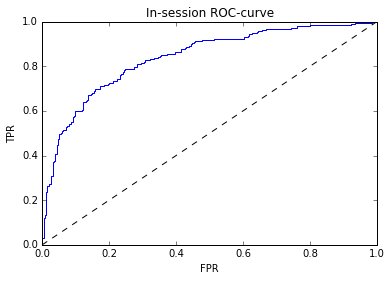

In [25]:
roc_curve_data_in = roc_curve(recalls_array,recall_prob_array)
fpr_in = roc_curve_data_in[0]
tpr_in = roc_curve_data_in[1]
plt.plot(fpr_in,tpr_in)
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('In-session ROC-curve')

However to asses reall value of the classifier wee need to test it on the data differennt than the training data (out-session data). We already have validation dataset solet's use it to compute out-session AUC and ROC curve:

In [26]:
validation_recall_prob_array = lr_classifier.predict_proba(validation_data)[:,1]
validation_auc = roc_auc_score(validation_recalls_array, validation_recall_prob_array)
validation_auc


0.70938852679237785

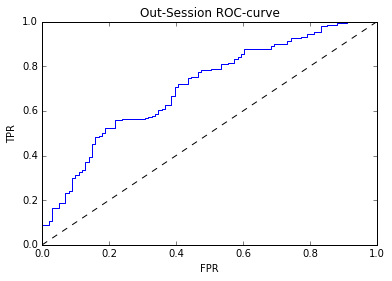

In [27]:
roc_curve_data_out = roc_curve(validation_recalls_array, validation_recall_prob_array)
fpr_out = roc_curve_data_out[0]
tpr_out = roc_curve_data_out[1]
plt.plot(fpr_out,tpr_out)
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Out-Session ROC-curve')

Notice that in our example we used entire data set (training + x-validation) during z-scoring. In real applications  we will have training data set which we will z-score and then then we will compute z-score for the training dataset separately (possibly using variance estimate for the training set). However in order to keep this tutorial relatively simple i made simplifying assumption and zscored entire data set.

In [28]:
time()-start_time

168.18399286270142

For logistic regression classifier we estimate probabilities that a given event belongs to a a class of recalled events. The probability formula is given by:

$P(x)=\left({1+e^{-\left(B+\sum w_i x_i\right)}}\right)^{-1}$

which implies that we are looking for a dividing hyperplane that will separate recalled and non-recalled events. The equation of this hyperplane is simply

$B+\sum w_i x_i = 0$

where $B$ is the intercept and $w_i$'s are weights coefficients fitted by Logistic Regression algorithm. $x_i$'s are features of the classifier - in our case $x_i$'s denote mean powers for the i-th combination of spectral frequency and bipolar pair. While ROC and AUC can give you a sense of classifier performance, sometimes it is nice to be able to visualize how well the dividing hyperplane separates data points belonging to thtw two classes (here recalled vs non recalled) We can do it by projecting N dimensional space into two dimennsions and plot dividing plane as well as individual , color-coded events. Let's rewrite $B+\sum w_i x_i = 0$ as 

$ B+X+Y = 0 $ where $X = \sum_{i=0}^{i=200} w_i x_i$ and $Y = \sum_{i=201}^{i=N} w_i x_i$. The number 200 is arbitrary here. The idea is that we can treat a weighted sum of first n features as one variable and the weighted sum of the remaining features as another variable and plot those on a scatter plot. Here I picked $n=200$ and $N$ denotes total number of features. Since $ B+X+Y = 0 $ is the exponent in the logistic probability function the line along which the probability of the data point belonging to either class is exactly 0.5 is called dividing line. It is not hard to see that the equation of hte dividing line is exactly 
$ B+X+Y = 0 $
because when the exponent is $0$ then 

$P(x)=\left({1+e^{-0}}\right)^{-1}=0.5$

Now, the data points that lie above the dividing line will get assigned high probability (here, of being recalled) and those that lie below will get assigned low probability

In [29]:
w_tmp = np.squeeze(lr_classifier.coef_)


array([ 0.00228864, -0.00282099,  0.00977253, ..., -0.00185081,
        0.00932513,  0.00708427])

In [30]:
w=np.zeros(len(w_tmp)+1)
w[0]=lr_classifier.intercept_
w[1:]=w_tmp

In [35]:
x_project=np.dot(training_data[:,:200],w[1:201])
y_project=np.dot(training_data[:,200:],w[201:])
recalled_ind = recalls_array==0

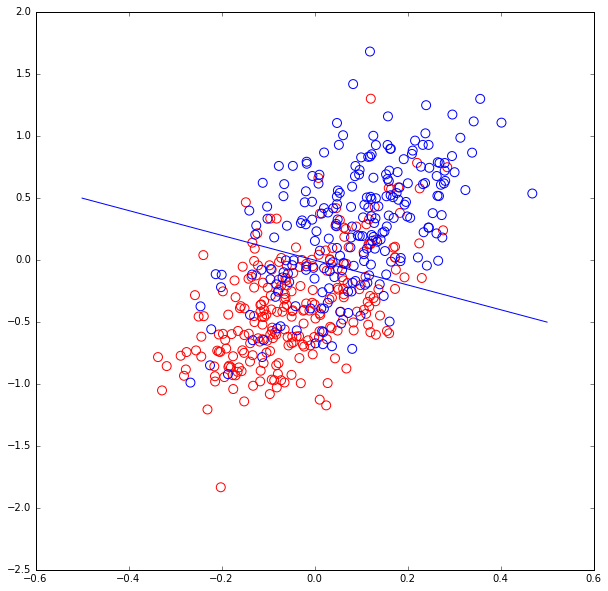

In [39]:
fig = plt.figure(figsize=(10, 10))

# plt.plot(x_line, y_line)
# plt.ylabel('uniform sample')
x = np.linspace(-.5,.5)
plt.plot(x, -w[0]-x)
plt.scatter(x=x_project[recalled_ind], y=y_project[recalled_ind], s=80, facecolors='none', edgecolors='r')
plt.scatter(x=x_project[~recalled_ind], y=y_project[~recalled_ind], s=80, facecolors='none', edgecolors='b')


The analogous plot for the validation data would look as follows

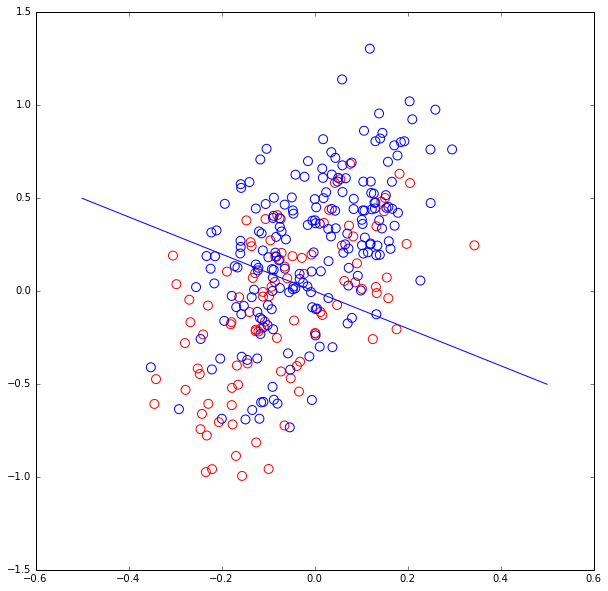

In [38]:
x_project_val=np.dot(validation_data[:,:200],w[1:201])
y_project_val=np.dot(validation_data[:,200:],w[201:])
validation_recalled_ind = validation_recalls_array==0
fig = plt.figure(figsize=(10, 10))

# plt.plot(x_line, y_line)
# plt.ylabel('uniform sample')
x = np.linspace(-.5,.5)
plt.plot(x, -w[0]-x)
plt.scatter(x=x_project_val[validation_recalled_ind], y=y_project_val[validation_recalled_ind], s=80, facecolors='none', edgecolors='r')
plt.scatter(x=x_project_val[~validation_recalled_ind], y=y_project_val[~validation_recalled_ind], s=80, facecolors='none', edgecolors='b')
